In [70]:
import sys
sys.path.append('d:/pythonProject/机器学习三/Customer-Analysis')
#请改为自己文件的绝对路径
from models.utils.feature_engineering import load_data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [71]:
data = load_data('d:/pythonProject/机器学习三/Customer-Analysis/data')
#请改为自己文件的绝对路径
print(f"number of features extracted: {len(data.columns)}")
print(data.shape)
print(data.head(5))

Extracting original data, data number: 2240, feature number: 29
number of features extracted: 30
(2216, 30)
      Education   Income  Kidhome  Teenhome  Recency  Wines  Fruits  Meat  \
0      Graduate  58138.0        0         0       58    635      88   546   
1      Graduate  46344.0        1         1       38     11       1     6   
2      Graduate  71613.0        0         0       26    426      49   127   
3      Graduate  26646.0        1         0       26     11       4    20   
4  Postgraduate  58293.0        1         0       94    173      43   118   

   Fish  Sweets  ...  AcceptedCmp2  Complain  Response       Customer_For  \
0   172      88  ...             0         0         1  57283200000000000   
1     2       1  ...             0         0         0   9763200000000000   
2   111      21  ...             0         0         0  26956800000000000   
3    10       3  ...             0         0         0  12009600000000000   
4    46      27  ...             0         0

d:\pythonProject/机器学习三/Customer-Analysis\models\utils\feature_engineering.py:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]


**首先使用pca降维，再进行聚类**

In [72]:
#Creating a copy of data
from sklearn.preprocessing import StandardScaler
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
ds = ds.select_dtypes(include=['float64', 'int64'])
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

All features are now scaled
Dataframe to be used for further modelling:


,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
0,0.234063,-0.823039,-0.928972,0.310532,0.978226,1.549429,1.690227,2.454568,1.484827,0.850031,...,1.428553,2.504712,-0.554143,0.693232,1.529129,0.986443,1.675488,-1.264803,-1.758673,-1.581389
1,-0.234559,1.039938,0.909066,-0.380509,-0.872024,-0.637328,-0.717986,-0.651038,-0.633880,-0.732867,...,-1.125881,-0.571082,-1.169518,-0.131574,-1.188411,1.236801,-0.962358,1.405806,0.450009,0.632356
2,0.769478,-0.823039,-0.928972,-0.795134,0.358511,0.569159,-0.178368,1.340203,-0.146821,-0.037937,...,1.428553,-0.229327,1.291982,-0.543978,-0.205155,0.318822,0.280250,-1.264803,-0.654332,-1.581389
3,-1.017239,1.039938,-0.928972,-0.795134,-0.872024,-0.561922,-0.655551,-0.504892,-0.585174,-0.752171,...,-0.760962,-0.912837,-0.554143,0.280829,-1.059945,-1.266777,-0.919224,0.070501,0.450009,0.632356
4,0.240221,1.039938,-0.928972,1.554407,-0.391671,0.418348,-0.218505,0.152766,-0.000703,-0.559135,...,0.333796,0.112428,0.061232,-0.131574,-0.951244,-1.016420,-0.307044,0.070501,0.450009,0.632356


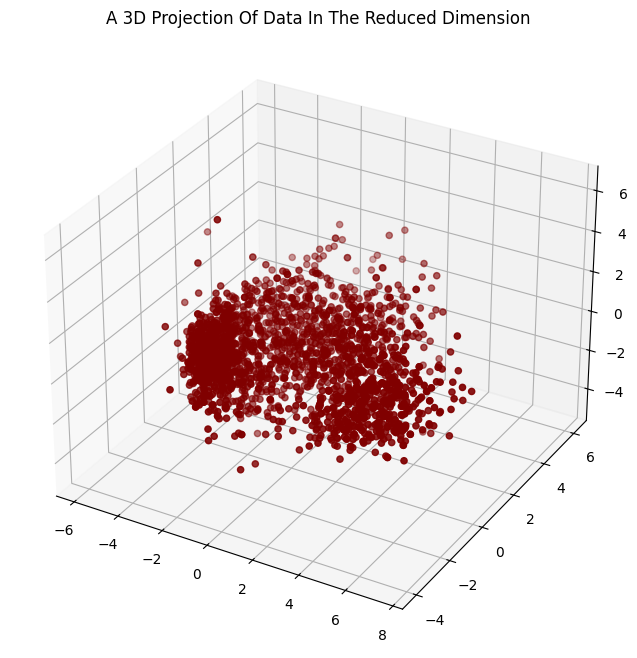

In [73]:
#Initiating PCA to reduce dimentions aka features to 3
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

Best parameters: eps=0.9999999999999999, min_samples=6
Number of clusters: 102
Number of noise points: 103
Best silhouette score: 0.0021024497887846966


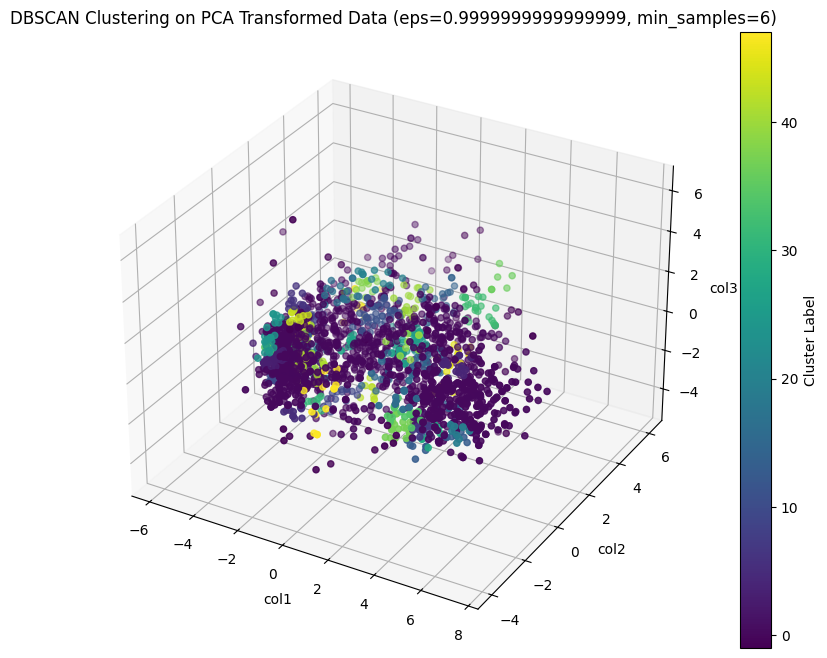

In [88]:
from models.Density.density_model import DBSCAN
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score
from itertools import product
import matplotlib.pyplot as plt

# 定义参数网格
eps_range = np.linspace(0.1, 2.0, 20)  # eps的范围
min_samples_range = range(3, 10)  # min_samples的范围

best_params = None
best_score = -1  # 初始轮廓系数设置为最差值
best_num_clusters = None
best_num_noise = None

# 进行网格搜索
for eps, min_samples in product(eps_range, min_samples_range):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    PCA_ds['cluster'] = dbscan.fit_predict(PCA_ds)
    
    # 获取聚类标签，排除噪声点（标签为-1的点）
    labels = PCA_ds['cluster'].values
    filtered_data = PCA_ds[labels != -1]
    
    # 如果聚类中有有效的簇，计算轮廓系数
    if len(filtered_data) > 0 and len(np.unique(labels[labels != -1])) > 1:
        silhouette = silhouette_score(filtered_data[['col1', 'col2', 'col3']], filtered_data['cluster'])
        
        # 计算噪声点的数量
        num_noise = list(PCA_ds['cluster']).count(-1)
        
        # 计算综合评分：目标是最大化轮廓系数并最小化噪声点数量
        score = silhouette - 0.0005 * num_noise  # 使用0.1的权重来调节噪声点的影响
        
        # 如果当前评分更高，更新最佳参数
        if score > best_score:
            best_score = score
            best_params = (eps, min_samples)
            best_num_clusters = len(set(PCA_ds['cluster'])) - (1 if -1 in PCA_ds['cluster'] else 0)
            best_num_noise = num_noise

# 输出最佳参数、聚类数量和噪声点数量
print(f"Best parameters: eps={best_params[0]}, min_samples={best_params[1]}")
print(f"Number of clusters: {best_num_clusters}")
print(f"Number of noise points: {best_num_noise}")
print(f"Best silhouette score: {best_score}")

# 使用最优参数进行最终的聚类
best_eps, best_min_samples = best_params
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
PCA_ds['cluster'] = dbscan.fit_predict(PCA_ds)

# 可视化聚类结果（三维）
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 使用col1, col2, col3进行三维可视化
scatter = ax.scatter(PCA_ds['col1'], PCA_ds['col2'], PCA_ds['col3'], c=PCA_ds['cluster'], cmap='viridis', marker='o')

# 标注
ax.set_xlabel('col1')
ax.set_ylabel('col2')
ax.set_zlabel('col3')
ax.set_title(f'DBSCAN Clustering on PCA Transformed Data (eps={best_eps}, min_samples={best_min_samples})')

# 显示颜色条
fig.colorbar(scatter, ax=ax, label='Cluster Label')

plt.show()


**直接进行聚类，随后用pca降维可视化展示**


Best parameters: eps=2.0, min_samples=3
Number of clusters: 41
Number of noise points: 1101
Best silhouette score: -0.7349708111424893


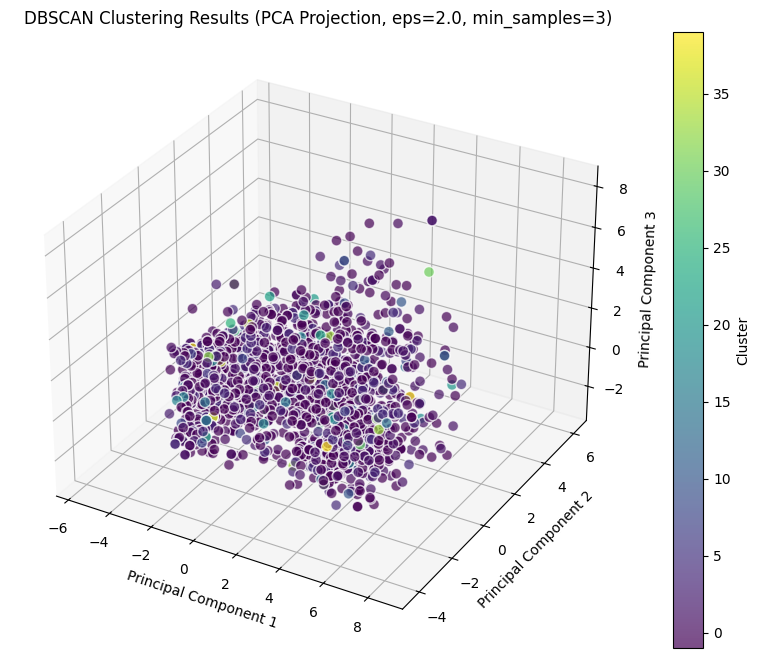

In [96]:
# 定义参数网格
eps_range = np.linspace(0.1, 2.0, 20)  # eps的范围
min_samples_range = range(3, 10)  # min_samples的范围

best_params = None
best_score = -1  # 初始轮廓系数设置为最差值
best_num_clusters = None
best_num_noise = None

# 使用 StandardScaler 进行标准化
scaler = StandardScaler()
# 选择数值型列进行标准化，排除非数值型列（如 'Education' 和 'Living_With'）
data_numeric = data.select_dtypes(include=['float64', 'int64'])

# 对每一列单独进行标准化
data_standardized = data_numeric.apply(lambda col: scaler.fit_transform(col.values.reshape(-1, 1)).flatten())
# 将标准化后的数据重新赋值回原数据
data[data_numeric.columns] = data_standardized

# 进行网格搜索
for eps, min_samples in product(eps_range, min_samples_range):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    data['cluster'] = dbscan.fit_predict(data_standardized)
    
    # 获取聚类标签，排除噪声点（标签为-1的点）
    labels = data['cluster'].values
    filtered_data = data[labels != -1]
    
    # 如果聚类中有有效的簇，计算轮廓系数
    if len(filtered_data) > 0 and len(np.unique(labels[labels != -1])) > 1:
        # 使用标准化后的数据进行轮廓系数计算
        silhouette = silhouette_score(filtered_data[data_numeric.columns], filtered_data['cluster'])
        
        # 计算噪声点的数量
        num_noise = list(data['cluster']).count(-1)
        
        # 计算综合评分：目标是最大化轮廓系数并最小化噪声点数量
        score = silhouette - 0.001 * num_noise  # 使用0.1的权重来调节噪声点的影响
        
        # 如果当前评分更高，更新最佳参数
        if score > best_score:
            best_score = score
            best_params = (eps, min_samples)
            best_num_clusters = len(set(data['cluster'])) - (1 if -1 in data['cluster'] else 0)
            best_num_noise = num_noise

# 输出最佳参数、聚类数量和噪声点数量
print(f"Best parameters: eps={best_params[0]}, min_samples={best_params[1]}")
print(f"Number of clusters: {best_num_clusters}")
print(f"Number of noise points: {best_num_noise}")
print(f"Best silhouette score: {best_score}")

# 使用最优参数进行最终的聚类
best_eps, best_min_samples = best_params
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
data['cluster'] = dbscan.fit_predict(data_standardized)

# 使用 PCA 降维至三维
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data_standardized)

# 创建一个新的 DataFrame，用于存储 PCA 降维后的数据
data_pca_df = pd.DataFrame(data_pca, columns=['PC1', 'PC2', 'PC3'])

# 将聚类结果（cluster）添加到降维后的数据中
data_pca_df['cluster'] = data['cluster']

# 三维可视化聚类结果
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 使用PC1, PC2, PC3进行三维散点图绘制
scatter = ax.scatter(data_pca_df['PC1'], data_pca_df['PC2'], data_pca_df['PC3'],
                     c=data_pca_df['cluster'], cmap='viridis', s=60, edgecolor='w', alpha=0.7)

# 设置图表标题和轴标签
ax.set_title(f'DBSCAN Clustering Results (PCA Projection, eps={best_eps}, min_samples={best_min_samples})')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# 显示颜色条
fig.colorbar(scatter, ax=ax, label='Cluster')

# 显示图形
plt.show()
